<a href="https://colab.research.google.com/github/mshitie/MS_KD/blob/main/Teacher%26Student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install rarfile

from google.colab import drive
import rarfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to the .rar file in Google Drive
rar_path = '/content/drive/MyDrive/computer_vision/main_data_croped.rar'

# Destination folder to extract the contents
destination_folder = '/content'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Extract the .rar file
with rarfile.RarFile(rar_path, 'r') as rar_ref:
    rar_ref.extractall(destination_folder)

print("Extraction completed.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extraction completed.


In [34]:
import os
import cv2
from PIL import Image
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_curve
from tqdm import tqdm

import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Lambda, concatenate, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow.keras.losses import categorical_crossentropy as logloss
from tensorflow.keras.metrics import categorical_accuracy

!pip install tensorflow-addons
import tensorflow_addons as tfa
import random

<ipython-input-34-2e4b0d649a65>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [35]:
# Set the path to the directory containing the dataset
dataset_dir = '/content/main_data_croped'

# Read the CSV file
data = pd.read_csv(os.path.join(dataset_dir, '/content/drive/MyDrive/computer_vision/tfti2.csv'), usecols=["key", "class"])

# Convert the 'class' column to string
data['class'] = data['class'].astype(str)

# Filter the data to include only classes 1 and 2
data = data[data['class'].isin(['1','2','3'])]

# Split the data into training, validation, and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)
valid_data, test_data = train_test_split(test_data, test_size=0.5, random_state=0)

# Print the number of samples in each set
print('Number of train samples:', train_data.shape[0])
print('Number of valid samples:', valid_data.shape[0])
print('Number of test samples:', test_data.shape[0])

# Preprocess data
train_data["key"] = train_data["key"].apply(lambda x: x + ".jpg")
valid_data["key"] = valid_data["key"].apply(lambda x: x + ".jpg")
test_data["key"] = test_data["key"].apply(lambda x: x + ".jpg")

BATCH_SIZE = 16
HEIGHT = 224
WIDTH = 224
N_CLASSES = 3

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=360,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=dataset_dir,
    x_col="key",
    y_col="class",
    class_mode="categorical", # binary for two class
    batch_size=BATCH_SIZE,
    target_size=(HEIGHT, WIDTH),
    seed=0
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=360,
    horizontal_flip=True,
    vertical_flip=True
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_data,
    directory=dataset_dir,
    x_col="key",
    y_col="class",
    class_mode="categorical", # binary for two class
    batch_size=BATCH_SIZE,
    target_size=(HEIGHT, WIDTH),
    seed=0
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=dataset_dir,
    x_col="key",
    batch_size=BATCH_SIZE,
    class_mode="categorical", # binary for two class
    shuffle=False,
    target_size=(HEIGHT, WIDTH),
    seed=0
)

Number of train samples: 1195
Number of valid samples: 149
Number of test samples: 150
Found 1195 validated image filenames belonging to 3 classes.
Found 149 validated image filenames belonging to 3 classes.
Found 150 validated image filenames belonging to 3 classes.


In [36]:
# Teacher model with ResNet50
def build_model(backbone , lr = 1e-4):
  model = Sequential()
  model.add(backbone)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dropout(0.5))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(1 , activation='softmax'))

  model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )

  return model

resnet = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224 , 224 , 3)
)
# call the model
model = build_model(resnet , lr = 1e-4)
model.build((None, 224, 224, 3))
model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_3 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                       

In [37]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,verbose=1,factor=0.2, min_lr=1e-4)
filepath="ResNet50weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
# Training the teacher model with Resnet50
# Train the teacher model as usual
# Configuration
import time
epochs = 10
batch_size = 64

# Calculate the starting time
start_time = time.time()

teacher_his = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    verbose=2,
            callbacks=[learn_control, checkpoint])


end_time = time.time()
print("--- Time taken to train : %s seconds ---" % ((end_time - start_time)))

Epoch 1/10


75/75 - 42s - loss: 0.6854 - accuracy: 0.3333 - val_loss: 0.6372 - val_accuracy: 0.3333 - lr: 1.0000e-04 - 42s/epoch - 557ms/step
Epoch 2/10


75/75 - 26s - loss: 0.6612 - accuracy: 0.3333 - val_loss: 0.6499 - val_accuracy: 0.3333 - lr: 1.0000e-04 - 26s/epoch - 352ms/step
Epoch 3/10


75/75 - 25s - loss: 0.6440 - accuracy: 0.3333 - val_loss: 0.6387 - val_accuracy: 0.3333 - lr: 1.0000e-04 - 25s/epoch - 334ms/step
Epoch 4/10


75/75 - 27s - loss: 0.6404 - accuracy: 0.3333 - val_loss: 0.6372 - val_accuracy: 0.3333 - lr: 1.0000e-04 - 27s/epoch - 360ms/step
Epoch 5/10


75/75 - 24s - loss: 0.6395 - accuracy: 0.3333 - val_loss: 0.6368 - val_accuracy: 0.3333 - lr: 1.0000e-04 - 24s/epoch - 318ms/step
Epoch 6/10


75/75 - 24s - loss: 0.6392 - accuracy: 0.3333 - val_loss: 0.6366 - val_accuracy: 0.3333 - lr: 1.0000e-04 - 24s/epoch - 323ms/step
Epoch 7/10


In [8]:
model.save_weights("ResNet50_model.h5") #using h5 extension
print("model saved!!!")

model saved!!!


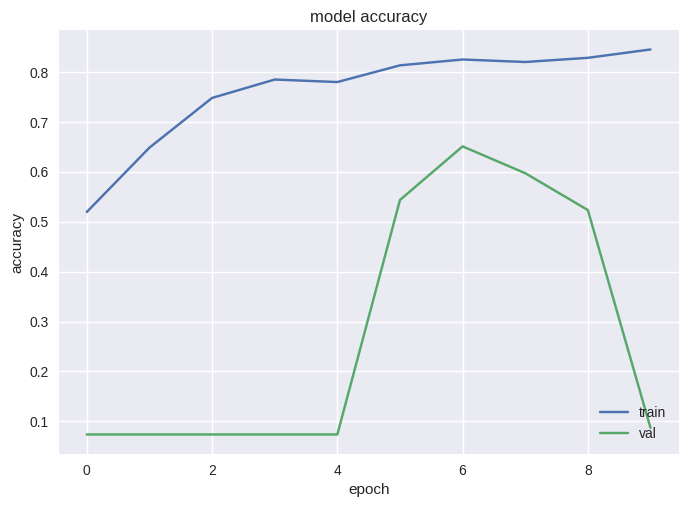

In [9]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['accuracy'],)
plt.plot(teacher_his.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

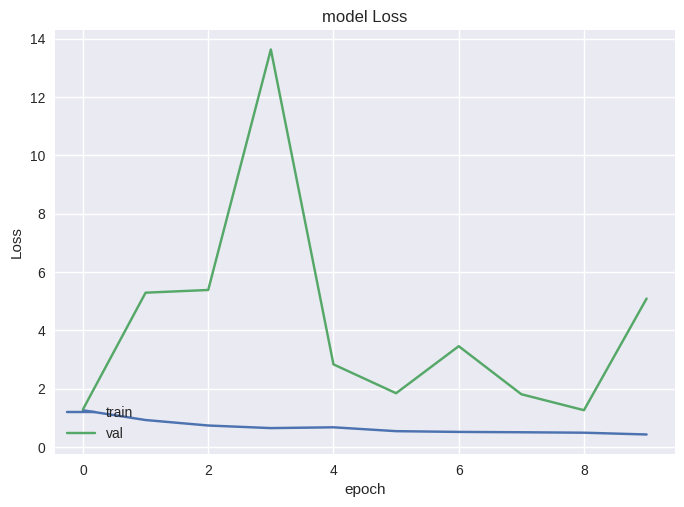

In [10]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['loss'])
plt.plot(teacher_his.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

In [12]:
#Y_val_pred = model.predict(x_val)
#print(f'The Teacher model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1)))

# Obtain predictions on the validation set
Y_val_pred = model.predict(valid_generator)
val_accuracy = accuracy_score(valid_generator.classes, np.argmax(Y_val_pred, axis=1))
print(f'The Teacher model Accuracy on the Validation Set: {val_accuracy}')

10/10 [==============================] - 4s 196ms/step
The Teacher model Accuracy on the Validation Set: 0.08053691275167785


In [13]:
#Now let's check my Y_test values
#print(f'My Y_test values are:\n' ,Y_test)


# Obtain predictions on the validation set
x_val, y_val = valid_generator.next()
Y_val_pred = model.predict(x_val)
val_accuracy = accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))
print(f'The Teacher model Accuracy on the Validation Set: {val_accuracy}')

1/1 [==============================] - 2s 2s/step
The Teacher model Accuracy on the Validation Set: 0.0625


In [18]:
# Now let's check my Y_test values
import timeit

start = timeit.default_timer()

# Obtain predictions on the test set
x_test, y_test = test_generator.next()
y_pred = model.predict(x_test)

# Convert predictions to class labels
Y_test = np.argmax(y_test, axis=1)
Y_pred = np.argmax(y_pred, axis=1)

print(f'My Y_test values are:\n', Y_test)

stop = timeit.default_timer()
print('\nTime:', stop - start, 'sec')

1/1 [==============================] - 0s 66ms/step
My Y_test values are:
 [0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0]

Time: 0.3406266389999928 sec


In [16]:
# Now let's check my predicted values from X_test dataset
# And calculate the y_pred with time
import timeit

start = timeit.default_timer()

# Obtain predictions on the test set
x_test, y_test = test_generator.next()
y_pred = model.predict(x_test)
print(f'My predicted Y_test values are:\n', y_pred)

stop = timeit.default_timer()
print('\nTime:', stop - start, 'sec')

1/1 [==============================] - 0s 41ms/step
My predicted Y_test values are:
 [[1.0457967e-08 6.2394225e-05 9.9993753e-01]
 [2.1202357e-01 1.7122252e-02 7.7085418e-01]
 [7.0592664e-06 2.4810695e-04 9.9974483e-01]
 [4.7137666e-05 1.7644282e-04 9.9977642e-01]
 [1.4100568e-03 2.2707528e-03 9.9631917e-01]
 [1.8253686e-02 1.4342893e-02 9.6740335e-01]
 [2.9010081e-04 1.2758122e-03 9.9843413e-01]
 [1.4975803e-02 3.9668102e-03 9.8105741e-01]
 [2.5788022e-02 8.0826273e-03 9.6612930e-01]
 [7.5472616e-02 1.2317215e-02 9.1221017e-01]
 [3.3781093e-02 1.3080486e-02 9.5313835e-01]
 [6.2122303e-03 5.1194015e-03 9.8866838e-01]
 [2.7255197e-03 4.9118767e-03 9.9236262e-01]
 [3.9744243e-04 9.4523793e-04 9.9865735e-01]
 [6.5532692e-02 1.6342736e-03 9.3283302e-01]
 [7.3706993e-04 6.6163619e-03 9.9264657e-01]]

Time: 0.25815076499998213 sec


In [19]:
import timeit
from sklearn.metrics import accuracy_score

start = timeit.default_timer()

# Obtain predictions on the test set
x_test, y_test = test_generator.next()
y_pred = model.predict(x_test)

# Convert predictions to class labels
Y_test = np.argmax(y_test, axis=1)
Y_pred = np.argmax(y_pred, axis=1)

# Evaluate accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print(f'My accuracy on Teacher model with ResNet50 on the Test set is: {accuracy}')

stop = timeit.default_timer()
print('\nTime:', stop - start, 'sec')

1/1 [==============================] - 0s 48ms/step
My accuracy on Teacher model with ResNet50 on the Test set is: 0.125

Time: 0.35550238199994055 sec


In [20]:
from sklearn.metrics import classification_report

# Obtain predictions on the test set
x_test, y_test = test_generator.next()
y_pred = model.predict(x_test)

# Convert predictions to class labels
Y_test = np.argmax(y_test, axis=1)
Y_pred = np.argmax(y_pred, axis=1)

# Print classification report
print('Classification Report of ResNet50:')
print(classification_report(Y_test, Y_pred))

1/1 [==============================] - 0s 117ms/step
Classification Report of ResNet50:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      14.0
           1       0.00      0.00      0.00       2.0
           2       0.00      0.00      0.00       0.0

    accuracy                           0.00      16.0
   macro avg       0.00      0.00      0.00      16.0
weighted avg       0.00      0.00      0.00      16.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

**AUC ROC**

Auc Curve on Validation:



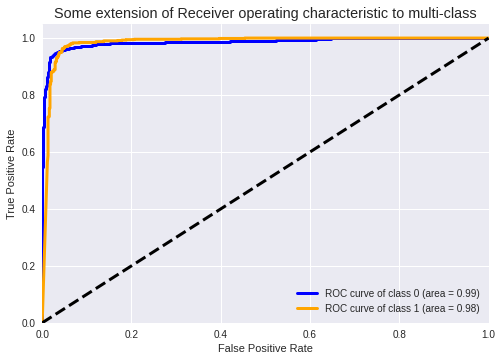

In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Validation:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], Y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), Y_val_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['blue', 'orange', 'cornflowerblue'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Test set:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['blue', 'orange', 'cornflowerblue'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

**Student Model**

In [ ]:
# Define the student model
# Student model that is stand-alone. We will evaluate its accuracy compared to a teacher trained student model
# Hyperparameters
input_shape = (224, 224, 3) # Input shape of each image
nb_classes = 2

customstudent = Sequential()
customstudent.add(Conv2D(128, kernel_size=(3, 3),activation='relu', input_shape=input_shape))
customstudent.add(MaxPooling2D(pool_size=(2, 2)))
customstudent.add(Conv2D(64, (3, 3), activation='relu'))
customstudent.add(MaxPooling2D(pool_size=(2, 2)))
customstudent.add(Conv2D(32, (3, 3), activation='relu'))
customstudent.add(Dropout(0.25)) # For reguralization

customstudent.add(layers.Flatten())

customstudent.add(layers.Dense(nb_classes))
customstudent.add(layers.Activation('softmax')) # Note that we add a normal softmax layer to begin with


customstudent.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

print(customstudent.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 32)        18464     
_________________________________________________________________
dropout_3 (Dropout)          (None, 52, 52, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)            

In [ ]:
# Define a new model that outputs only teacher logits
# Raise the temperature of teacher model and gather the soft targets

# Collect the logits from the previous layer output and store it in a different model
teacher_WO_Softmax = Model(model.input, model.get_layer('dense_2').output)

In [ ]:
# Define a manual softmax function
def softmax(x):
    return np.exp(x)/(np.exp(x).sum())

In [ ]:
# Prepare the soft targets and the target data for student to be trained upon
# From our temperature experiment we get temp = 10 is gave is best results
temp = 10
# This model directly gives the logits ( see the teacher_WO_softmax model above)
teacher_train_logits = teacher_WO_Softmax.predict(x_train)
teacher_test_logits = teacher_WO_Softmax.predict(x_val)

# Perform a manual softmax at raised temperature
train_logits_T = teacher_train_logits/ temp # temp = 10
test_logits_T = teacher_test_logits / temp

Y_train_soft = softmax(train_logits_T)
Y_test_soft = softmax(test_logits_T)

# Concatenate
Y_train_new = np.concatenate([y_train, Y_train_soft], axis=1)
Y_test_new =  np.concatenate([y_val, Y_test_soft], axis =1)

#Print the Shape
print(train_logits_T.shape)
print(test_logits_T.shape)
print(Y_train_new.shape)
print(Y_test_new.shape)

(5596, 2)
(1400, 2)
(5596, 4)
(1400, 4)


In [ ]:
# Prepare the student model that outputs probabilities with and without temperature
# Remove the softmax layer from the student network
temp = 10
customstudent.layers.pop()

# Now collect the logits from the last layer
# This is going to be a tensor. And hence it needs to pass through a Activation layer
logits = customstudent.layers[-1].output
probs = layers.Activation('softmax')(logits)


# softed probabilities at raised temperature
logits_T = Lambda(lambda x: x / temp)(logits)
probs_T = layers.Activation('softmax')(logits_T)

output = concatenate([probs, probs_T])

# This is our new student model
customstudent = Model(customstudent.input, output)

customstudent.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_input (InputLayer)       [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 222, 222, 128 3584        conv2d_input[0][0]               
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 111, 111, 128 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 109, 109, 64) 73792       max_pooling2d[0][0]              
____________________________________________________________________________________________

In [ ]:
# Declare knowledge distillation loss function
# This will be a teacher trained student model.
# This uses a knowledge distillation loss function
# Declare knowledge distillation loss
def knowledge_distillation_loss(y_true, y_pred, alpha):

    # Extract the one-hot encoded values and the softs separately so that we can create two objective functions
    y_true, y_true_softs = y_true[: , :nb_classes], y_true[: , nb_classes:]

    y_pred, y_pred_softs = y_pred[: , :nb_classes], y_pred[: , nb_classes:]

    loss = alpha*logloss(y_true,y_pred) + (1-alpha)*logloss(y_true_softs, y_pred_softs)

    return loss

# For testing use regular output probabilities - without temperature
def acc(y_true, y_pred):
    y_true = y_true[:, :nb_classes]
    y_pred = y_pred[:, :nb_classes]
    return categorical_accuracy(y_true, y_pred)

customstudent.compile(
    #optimizer=optimizers.SGD(lr=1e-1, momentum=0.9, nesterov=True),
    optimizer='adadelta',
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, 0.1),
    #loss='categorical_crossentropy',
    metrics=[acc]
  )

In [ ]:
# Train the student model
epochs = 20
batch_size = 64
customstudent_student_his = customstudent.fit(x_train, Y_train_new,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, Y_test_new))

Epoch 1/20
88/88 [==============================] - 16s 184ms/step - loss: 0.0441 - acc: 0.8710 - val_loss: 0.0442 - val_acc: 0.8750
Epoch 2/20
88/88 [==============================] - 16s 184ms/step - loss: 0.0439 - acc: 0.8733 - val_loss: 0.0448 - val_acc: 0.8671
Epoch 3/20
88/88 [==============================] - 16s 185ms/step - loss: 0.0434 - acc: 0.8788 - val_loss: 0.0442 - val_acc: 0.8750
Epoch 4/20
88/88 [==============================] - 16s 185ms/step - loss: 0.0439 - acc: 0.8740 - val_loss: 0.0443 - val_acc: 0.8721
Epoch 5/20
88/88 [==============================] - 16s 185ms/step - loss: 0.0437 - acc: 0.8763 - val_loss: 0.0442 - val_acc: 0.8750
Epoch 6/20
88/88 [==============================] - 16s 186ms/step - loss: 0.0439 - acc: 0.8742 - val_loss: 0.0444 - val_acc: 0.8721
Epoch 7/20
88/88 [==============================] - 16s 186ms/step - loss: 0.0435 - acc: 0.8783 - val_loss: 0.0442 - val_acc: 0.8743
Epoch 8/20
88/88 [==============================] - 16s 186ms/step - 

In [ ]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.style.use('seaborn')
plt.plot(customstudent_student_his.history['acc'])
plt.plot(customstudent_student_his.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [ ]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(customstudent_student_his.history['loss'])
plt.plot(customstudent_student_his.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
Y_val_pred_student = customstudent.predict(x_val)
print(f'The CustomStudent model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred_student, axis=1)))

The CustomStudent model Accuracy on the Validation Set: 0.8785714285714286


In [ ]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,Y_test)

My Y_test values are:
 [[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [ ]:
#Now let's check my predcited values from X_test dataset
import timeit

start = timeit.default_timer()
#Your statements here
y_pred_student = customstudent.predict(X_test)
print(f'My predicted Y_test values are:\n' ,y_pred_student)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My predicted Y_test values are:
 [[0.73105854 0.26894143 0.5249792  0.4750208 ]
 [0.26894143 0.73105854 0.4750208  0.5249792 ]
 [0.73105854 0.26894143 0.5249792  0.4750208 ]
 ...
 [0.73105854 0.2689415  0.5249792  0.47502083]
 [0.31061557 0.68938446 0.4800795  0.5199205 ]
 [0.73105854 0.26894143 0.5249792  0.4750208 ]]

Time:  2.5788797919994977 sec


In [ ]:
start = timeit.default_timer()
#Your statements here

#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy on Custom Student model on the Test set is:',accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred_student, axis=1)))

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My accuracy on Custom Student model on the Test set is: 0.9173333333333333

Time:  0.0009702650004328461 sec


In [ ]:
# Classification_report
print(f'Classification Report of Resnet50:\n',classification_report(np.argmax(Y_test, axis=1), np.argmax(y_pred_student, axis=1)))

Classification Report of Resnet50:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      1500
           1       0.96      0.87      0.91      1500

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



Auc Curve on Validation:



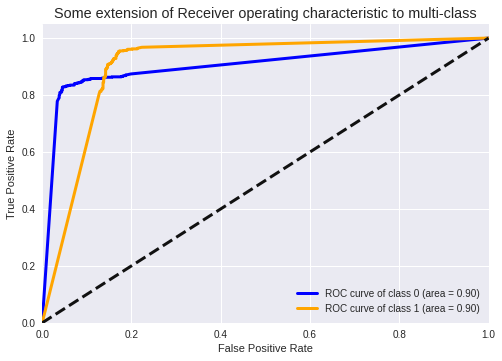

In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Validation:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_new[:, i], Y_val_pred_student[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_new.ravel(), Y_val_pred_student.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['blue', 'orange', 'cornflowerblue'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Auc Curve on Test set:



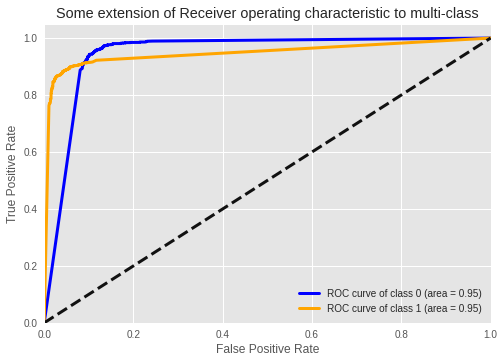

In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Test set:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred_student[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_pred_student.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['blue', 'orange', 'cornflowerblue'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

-----